In [1]:
"""
Extract gridMET variables for daily burn perimeters, western U.S.
Google Earth Engine (GEE) Python API
Author: maxwell.cook@colorado.edu
"""

import ee
import geemap
import time

ee.Authenticate()
ee.Initialize(project='jfsp-aspen')
print("GEE Authenticated !")

GEE Authenticated !


In [42]:
# Function to calculate gridmet for daily perimeters
def gridmet_summary(fires, reducer, attrs, buffer=None):
    """ Calculates the gridMET variables for a given daily perimeter by daily ID 
    Args:
        - fires: fire perimeters (with daily polygons)
        - reducer: the reduction to use for the gridmet variables
        - attrs: the gridmet variables
        - buffer: (optional) apply a buffer to the daily polygon
    """
    # Set a function to calculate the variables for each daily perimeter
    def get_daily_gridmet(perim):
        # Buffer if requested
        if buffer is not None:
            geom = perim.geometry().bounds().buffer(buffer)
        else:
            geom = perim.geometry().bounds()
        did = perim.get('did') # get the daily burn ID
        # Get the burn date for extracting gridMET variables
        burn_date = ee.Date(perim.get('date')) 
        gridmet_ = gridmet.filterDate(burn_date, burn_date.advance(1, 'day')).select(attrs)
        gridmet_mn = gridmet_.mean() # take the mean of the imageCollection (daily gridmets)
        # Set up the feature reduction
        stats = gridmet_mn.reduceRegion(
            reducer=reducer,
            geometry=geom,
            scale=4000,  # Match gridMET resolution
            bestEffort=True)
        return perim.set(stats)
    results = fires.map(get_daily_gridmet)
    return results

def parse_date(ftr, date_col):
    """ Function to safely parse a date column and raise error if the date is invalid """
    try:
        date_str = ee.String(ftr.get(date_col)).split(' ').get(0) # removes the time stamp
        # Try to parse the date using the provided format
        date = ee.Date.parse('YYYY/MM/dd', date_str)
        return ftr.set('date', date)
    except ee.EEException as e:
        # Raise an error or skip the feature if the date is invalid
        print(f"Error parsing date for feature with ID {ftr.get('did').getInfo()}: {str(e)}")
        return None  # Skip features with invalid dates

def check_dates(fc, date_col):
    """ Filters out features with invalid dates """
    valid_dates = fc.map(lambda ftr: parse_date(ftr, date_col)).filter(ee.Filter.notNull(['date']))
    return valid_dates

def monitor_export(task):
    """ Monitors EE export task """
    while task.active():
        print('Waiting for export to finish..\n\tPatience young padawan.')
        time.sleep(30)  # Check every 30 seconds
    
    # Get the status of the task
    status = task.status()
    
    # Check if the task failed or succeeded
    if status['state'] == 'COMPLETED':
        print("Export completed successfully !!!!")
    elif status['state'] == 'FAILED':
        print(f"Export failed! Bummer. Reason: {status.get('error_message', 'Unknown error')}")
    else:
        print(f"Export ended with state: {status['state']}")

print("Functions loaded !")

Functions loaded !


In [14]:
# Load the gridMET datasets
gridmet = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET')
print(f"gridMET bands available for analysis:\n\n{gridmet.first().bandNames().getInfo()}")

gridMET bands available for analysis:

['pr', 'rmax', 'rmin', 'sph', 'srad', 'th', 'tmmn', 'tmmx', 'vs', 'erc', 'eto', 'bi', 'fm100', 'fm1000', 'etr', 'vpd']


In [ ]:
# Implement the function

In [31]:
fires = ee.FeatureCollection('projects/jfsp-aspen/assets/fired-daily_west_2018_to_2024')
print(f"There are [{fires.size().getInfo()}] daily fire perimeters.")

# Parse the date column:
fires = check_dates(fires, 'date')
print(f"Successfully parsed dates for [{fires.size().getInfo()}] daily perimeters.")
print(f"Example date: {fires.first().get('date').getInfo()}")

There are [32493] daily fire perimeters.
Successfully parsed dates for [32493] daily perimeters.
Example date: {'type': 'Date', 'value': 1582934400000}


In [32]:
# Define the function parameters
reduction = ee.Reducer.percentile([95]) # 95th percentile
attrs = ['fm1000', 'vpd', 'erc', 'bi', 'tmmx', 'rmin', 'vs'] # the gridmet attributes to use
# Retrieve gridmet summaries for daily perimeters
results_fc = gridmet_summary(fires, reduction, attrs)
print("Success !")

Success !


In [33]:
# Check the results
results_fc.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-118.99755710339323, 35.05417427658838],
    [-118.99145840860311, 35.04999004807538],
    [-118.98634903602644, 35.04999023890428],
    [-118.9924474889566, 35.054174741246676],
    [-118.99755710339323, 35.05417427658838]]]},
 'id': '00000000000000004264',
 'properties': {'bi': 45,
  'date': {'type': 'Date', 'value': 1582934400000},
  'did': '0b908840d20743a1554d1ca3e1d42df8',
  'dy_ar_km2': 0.214658673296478,
  'eco_mode': 1,
  'eco_name': 'California Central Valley grasslands',
  'eco_type': 'WWF Terrestrial Ecoregions of the World',
  'erc': 52,
  'event_day': 1,
  'event_dur': 1,
  'fid': 1441,
  'fm1000': 12.899999618530273,
  'fsr_km2_dy': 0.214658673296478,
  'fsr_px_dy': 1,
  'id': 5247,
  'ig_date': '2020/02/29 00:00:00.000',
  'ig_day': '060',
  'ig_month': 2,
  'ig_utm_x': 3897618.156358264,
  'ig_utm_y': -10831556.656358264,
  'ig_year': 2020,
  'last_date': '2020/02/29 00:00:00.000',
  'lc_code': 13

In [39]:
# Subset and export (gridmet attributes and DID)
print(f"Export columns: {['did'] + attrs}")
results_fc_ = results_fc.select(attrs + ['did'])

Export columns: ['did', 'fm1000', 'vpd', 'erc', 'bi', 'tmmx', 'rmin', 'vs']


In [40]:
# Export the table to an asset
export_task = ee.batch.Export.table.toAsset(
    collection=results_fc_,
    description='fired-daily_west_2018_to_2024_gridmet',
    assetId='projects/jfsp-aspen/assets/fired-daily_west_2018_to_2024_gridmet' 
)
# Start the export task
export_task.start()
print("Export to Earth Engine Asset started!")
# Monitor the task until it's finished
monitor_export(export_task)

Export to Earth Engine Asset started!


In [43]:
# Export the FeatureCollection to Google Drive
export_task = ee.batch.Export.table.toDrive(
    collection=results_fc_,
    description='fired-daily_west_2018_to_2024_gridmet',
    fileFormat='CSV'
)
# Start the export task
export_task.start()
print("Export to Google Drive started!")
# Monitor the task until it's finished
monitor_export(export_task)

Export to Google Drive started!
Waiting for export to finish...
Waiting for export to finish...
Waiting for export to finish...
Waiting for export to finish...
Export completed successfully!


In [ ]:
# Load the newly created gridMET summary

In [47]:
import os
import pandas as pd
import geopandas as gpd

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')
ee_fp = os.path.join(projdir,'data/earth-engine/exports/')

In [53]:
fp = os.path.join(ee_fp, 'gridmet/fired-daily_west_2018_to_2024_gridmet.csv')
gridmet = pd.read_csv(fp)
gridmet.columns

Index(['system:index', 'bi', 'did', 'erc', 'fm1000', 'rmin', 'tmmx', 'vpd',
       'vs', '.geo'],
      dtype='object')

In [56]:
gridmet = gridmet[['did']+attrs]
gridmet.head()

,did,fm1000,vpd,erc,bi,tmmx,rmin,vs
0,0b908840d20743a1554d1ca3e1d42df8,12.9,1.68,52.0,45.0,299.600006,13.000000,3.6
1,69f8268bcd91b189bd105e19d077ff87,11.0,2.06,64.0,53.0,301.600006,7.000000,3.1
2,cd47945f2f92f94008851c6cff040dbe,5.2,1.09,87.0,50.0,291.600006,16.799999,1.3
3,73e34be581364f01f6094ff1fe7997ac,4.2,4.34,105.0,70.0,312.799988,3.100000,2.0
4,91725118b4a7318271f4fc3daba67e36,3.9,4.96,104.0,81.0,315.899994,8.600000,3.2


In [57]:
# Overwrite the file with this clean version
gridmet.to_csv(os.path.join(ee_fp, 'gridmet/fired-daily_west_2018_to_2024_gridmet.csv'))
print("Successfully overwrote the table.")

Successfully overwrote the table.


In [58]:
# Load the spatial polygons
fp = os.path.join(projdir, 'data/spatial/raw/FIRED/fired-daily_west_2018_to_2024.gpkg')
fired_daily = gpd.read_file(fp)
fired_daily.columns

Index(['did', 'id', 'date', 'ig_date', 'ig_day', 'ig_month', 'ig_year',
       'last_date', 'event_day', 'event_dur', 'pixels', 'tot_pix', 'dy_ar_km2',
       'tot_ar_km2', 'fsr_px_dy', 'fsr_km2_dy', 'mx_grw_px', 'mn_grw_px',
       'mu_grw_px', 'mx_grw_km2', 'mn_grw_km2', 'mu_grw_km2', 'mx_grw_dte',
       'x', 'y', 'ig_utm_x', 'ig_utm_y', 'lc_code', 'lc_mode', 'lc_name',
       'lc_desc', 'lc_type', 'eco_mode', 'eco_name', 'eco_type', 'geometry'],
      dtype='object')

In [ ]:
gc.collect()

In [ ]:
# Export a subset for the SRM

<Axes: >

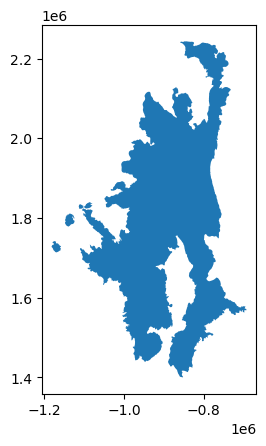

In [59]:
# Load the western U.S. ecoregions
fp = os.path.join(projdir,'data/spatial/mod/boundaries/na_cec_eco_l3_west.gpkg')
ecol3 = gpd.read_file(fp)
ecol3 = ecol3[['NA_L3NAME','geometry']]
ecol3 = ecol3.rename(columns={'NA_L3NAME': 'na_l3name'})
srm = ecol3[ecol3['na_l3name'] == 'Southern Rockies']
srm.plot()

In [64]:
if srm.crs != fired_daily.crs:
    srm = srm.to_crs(fired_daily.crs)
fired_daily_srm = gpd.sjoin(fired_daily, srm, how='inner', predicate='within')
fired_daily_srm.drop('index_right', axis=1, inplace=True)
print(f"There are [{len(fired_daily_srm)}] unique daily perimeters in the SRM (2018-2024).")

There are [1828] unique daily perimeters in the SRM (2018-2024).


In [65]:
# Filter the gridmet results
gridmet_srm = gridmet[gridmet['did'].isin(fired_daily_srm['did'])]
print(f"There are [{len(gridmet_srm)}] associated gridmet records.")

There are [1828] associated gridmet records.


In [66]:
# Save these files out.
out_dir = os.path.join(projdir,'data/spatial/mod/SRME/')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
fired_daily_srm.to_file(os.path.join(out_dir,'fired-daily_SRME_2018_to_2024.gpkg'))
gridmet_srm.to_csv(os.path.join(out_dir,'fired-daily_SRME_2018_to_2024_GRIDMET.csv'))
print("Successfully exported data and tables !")

Successfully exported data and tables !
